# Create model from scratch

In [1]:
# Import RPB model along with other utility functions

from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Product
from RPB_model import RotaryPackedBed

from pyomo.environ import (
    ConcreteModel,
    SolverFactory,
    TransformationFactory,
    Reference,
    units as pyunits,
    Param,
)

import idaes.core.util as iutil
import idaes.core.util.scaling as iscale
from idaes.core.util.model_statistics import degrees_of_freedom
import idaes.logger as idaeslog
from idaes.core.util.initialization import propagate_state

from idaes.models_extra.power_generation.properties import FlueGasParameterBlock
from idaes.models.properties.modular_properties.base.generic_property import (
    GenericParameterBlock,
)
from idaes.models_extra.power_generation.properties.natural_gas_PR import (
    get_prop,
    EosType,
)

from pyomo.network import Arc

from idaes.core.util.model_diagnostics import DiagnosticsToolbox

import numpy as np

In [2]:
# create Flowsheet block

m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic = False)

In [3]:
# create gas phase properties block
flue_species={"H2O", "CO2", "N2"}
prop_config = get_prop(flue_species, ["Vap"], eos=EosType.IDEAL)
prop_config["state_bounds"]["pressure"] = (0.99*1e5,1.02*1e5,1.2*1e5, pyunits.Pa)
prop_config["state_bounds"]["temperature"] = (25+273.15,90+273.15,180+273.15, pyunits.K)

m.fs.gas_props = GenericParameterBlock(
    **prop_config,
    doc = "Flue gas properties",
)

m.fs.gas_props.set_default_scaling("temperature", 1e-2)
m.fs.gas_props.set_default_scaling("pressure", 1e-4)

In [4]:
# create feed and product blocks

m.fs.flue_gas_in = Feed(property_package = m.fs.gas_props)
m.fs.flue_gas_out = Product(property_package = m.fs.gas_props)
m.fs.steam_sweep_feed = Feed(property_package = m.fs.gas_props)
m.fs.regeneration_prod = Product(property_package = m.fs.gas_props)

In [ ]:
# increased number of discretization points, lower mass balance error

# z_init_points=tuple(np.geomspace(0.01, 0.5, 9)[:-1]) + tuple((1 - np.geomspace(0.01, 0.5, 9))[::-1])
# o_init_points=tuple(np.geomspace(0.005, 0.1, 8)) + tuple(np.linspace(0.1, 0.995, 10)[1:])

# z_nfe=20
# o_nfe=20

# m.fs.RPB = RotaryPackedBed(
#     property_package = m.fs.gas_props,
#     z_init_points=z_init_points,
#     o_init_points=o_init_points,
#     z_nfe=z_nfe,
#     o_nfe=o_nfe,
# )

In [5]:
# limited discretization, much faster

m.fs.RPB = RotaryPackedBed(
    property_package = m.fs.gas_props,
    z_init_points = (0.01,0.99),
    o_init_points = (0.01,0.99),
)

In [6]:
# add stream connections

m.fs.s_flue_gas = Arc(source=m.fs.flue_gas_in.outlet, destination=m.fs.RPB.ads_gas_inlet)
m.fs.s_cleaned_flue_gas = Arc(source=m.fs.RPB.ads_gas_outlet, destination=m.fs.flue_gas_out.inlet)
m.fs.s_steam_feed = Arc(source=m.fs.steam_sweep_feed.outlet, destination=m.fs.RPB.des_gas_inlet)
m.fs.s_regeneration_prod = Arc(source=m.fs.RPB.des_gas_outlet, destination=m.fs.regeneration_prod.inlet)

TransformationFactory("network.expand_arcs").apply_to(m)

In [7]:
# fix state variables in feed and product blocks
# ads side
m.fs.flue_gas_in.pressure.fix(1.02*1e5)
m.fs.flue_gas_in.temperature.fix(90+273.15)
m.fs.flue_gas_out.pressure.fix(1.01325*1e5)
m.fs.flue_gas_in.mole_frac_comp[0,"CO2"].fix(0.04)
m.fs.flue_gas_in.mole_frac_comp[0,"H2O"].fix(0.09)
m.fs.flue_gas_in.mole_frac_comp[0,"N2"].fix(1-0.04-0.09)

#des side
m.fs.steam_sweep_feed.pressure.fix(1.05*1e5)
m.fs.steam_sweep_feed.temperature.fix(120+273.15)
m.fs.regeneration_prod.pressure.fix(1.01325*1e5)
m.fs.steam_sweep_feed.mole_frac_comp[0,"CO2"].fix(1e-5)
m.fs.steam_sweep_feed.mole_frac_comp[0,"N2"].fix(1e-3)
m.fs.steam_sweep_feed.mole_frac_comp[0,"H2O"].fix(1-1e-5-1e-3)

In [8]:
# fix design variables of the RPB

m.fs.RPB.ads.Tx.fix()
m.fs.RPB.des.Tx.fix()

m.fs.RPB.w_rpm.fix(0.1)

In [9]:
# check degrees of freedom

print("DOF =",degrees_of_freedom(m))

DOF = 0


In [10]:
# initialize feed and product blocks

m.fs.flue_gas_in.initialize()
m.fs.flue_gas_out.initialize()
m.fs.steam_sweep_feed.initialize()
m.fs.regeneration_prod.initialize()

2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_in.properties: Starting initialization
2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_in.properties: Property initialization: optimal - Optimal Solution Found.
2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_in.properties: Property package initialization: optimal - Optimal Solution Found.
2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_in: Initialization Complete.
2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_out.properties: Starting initialization
2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_out.properties: Property initialization: optimal - Optimal Solution Found.
2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_out.properties: Property package initialization: optimal - Optimal Solution Found.
2024-08-28 11:39:50 [INFO] idaes.init.fs.flue_gas_out: Initialization Complete.
2024-08-28 11:39:50 [INFO] idaes.init.fs.steam_sweep_feed.properties: Starting initialization
2024-08-28 11:39:50 [INFO] idaes.init.fs.steam_sweep_f

In [11]:
# propagate feed and product blocks (for initial RPB guesses)
propagate_state(arc = m.fs.s_flue_gas, direction="forward")
propagate_state(arc = m.fs.s_steam_feed, direction="forward")
propagate_state(arc = m.fs.s_cleaned_flue_gas, direction="backward")
propagate_state(arc = m.fs.s_regeneration_prod, direction="backward")

In [12]:
# Initialize RPB (about 4 mins for smaller discretization size and close to 20 mins for the larger size)

optarg = {
    # "halt_on_ampl_error": "yes",
    "max_iter": 1000,
    "bound_push": 1e-22,
    # "mu_init": 1e-3,
    "nlp_scaling_method": "user-scaling",
}

init_points = [1e-5,1e-3,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

m.fs.RPB.initialize(outlvl=idaeslog.INFO, optarg=optarg, initialization_points=init_points)

2024-08-28 11:40:02 [INFO] idaes.init.fs.RPB: Beginning Initialization
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.inlet_properties: Starting initialization
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.inlet_properties: State variable initialization completed.
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.inlet_properties: Property initialization: optimal - Optimal Solution Found.
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.inlet_properties: Property package initialization: optimal - Optimal Solution Found.
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.outlet_properties: Starting initialization
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.outlet_properties: State variable initialization completed.
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.outlet_properties: Property initialization: optimal - Optimal Solution Found.
2024-08-28 11:40:04 [INFO] idaes.init.fs.RPB.ads.outlet_properties: Property package initialization: optimal - Optimal Solution Found.
2024-08

In [13]:
# full solve with IPOPT

Solver = SolverFactory("ipopt")
Solver.solve(m, tee=True).write()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    con

In [ ]:
# can skip the initialization steps and load an already saved model then solve

# if using the smaller discretization
iutil.from_json(m, fname="RPB flowsheet 081924, limited disc.json.gz", gz=True)
# if using the larger discretization
# iutil.from_json(m, fname="RPB flowsheet 081924.json.gz", gz=True)

Solver = SolverFactory("ipopt")
Solver.solve(m, tee=True).write()

In [14]:
m.fs.report(dof=True)


Flowsheet : fs                                                             Time: 0.0
    Local Degrees of Freedom: 0
    Total Variables: 7504    Activated Constraints: 7023    Activated Blocks: 267
------------------------------------------------------------------------------------
    Stream Table
                                Units       s_flue_gas  s_cleaned_flue_gas  s_steam_feed  s_regeneration_prod
    Total Molar Flowrate     mole / second      80.176          77.114           168.43           173.00     
    Total Mole Fraction N2   dimensionless     0.87000         0.90455        0.0010000       0.00097358     
    Total Mole Fraction CO2  dimensionless    0.040000       0.0018765       1.0000e-05         0.026429     
    Total Mole Fraction H2O  dimensionless    0.090000        0.093574          0.99899          0.97260     
    Temperature                     kelvin      363.15          391.38           393.15           363.66     
    Pressure                        pa

In [15]:
m.fs.RPB.report(dof=True)


Unit : fs.RPB                                                              Time: 0.0
    Local Degrees of Freedom: 12
    Total Variables: 7415    Activated Constraints: 6979    Activated Blocks: 249
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value    : Units           : Fixed : Bounds
                 Adsorption Tx :   363.00 :          kelvin :  True : (0, None)
    Adsorption Volume Fraction :  0.75000 :   dimensionless :  True : (0.01, 0.99)
                   CO2 Capture :  0.95488 :   dimensionless : False : (None, None)
                 Desorption Tx :   393.00 :          kelvin :  True : (0, None)
    Desorption Volume Fraction :  0.25000 :   dimensionless : False : (0.01, 0.99)
                      Diameter :   10.000 :           meter :  True : (0, None)
                        Length :   3.0000 :           meter :  True : (0.1, 10.001)
           Rotational Vel

# Diagnostics testing

In [ ]:
diagtool = DiagnosticsToolbox(m)

In [ ]:
diagtool.display_constraints_with_extreme_jacobians()

In [ ]:
diagtool.display_variables_with_extreme_jacobians()

In [ ]:
diagtool.report_numerical_issues()

In [ ]:
diagtool.display_variables_with_extreme_values()

In [ ]:
diagtool.report_structural_issues()

In [ ]:
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)

    # print("Extreme Jacobian entries:")
    with open("extreme_jacobian_entries.txt", "w") as f:
        for i in iscale.extreme_jacobian_entries(
            jac=jac, nlp=nlp, small=1e-4, large=1e4
        ):
            print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]", file=f)

    # print("Extreme Jacobian Columns:")
    with open("extreme_jacobian_columns.txt", "w") as f:
        for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, small=1e-3, large=1e3
        ):
            print(f"    {i[0]:.2e}, [{i[1]}]", file=f)

    # print("Extreme Jacobian Rows:")
    with open("extreme_jacobian_rows.txt", "w") as f:
        for i in iscale.extreme_jacobian_rows(jac=jac, nlp=nlp, small=1e-3, large=1e3):
            print(f"    {i[0]:.2e}, [{i[1]}]", file=f)

    with open("badly_scaled_vars.txt", "w") as f:
        for v, sv in iscale.badly_scaled_var_generator(
            blk, large=1e4, small=1e-4, zero=1e-12
        ):
            print(f"    {v} -- {sv} -- {iscale.get_scaling_factor(v)}", file=f)

    print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

check_scaling(m)

# Plotting

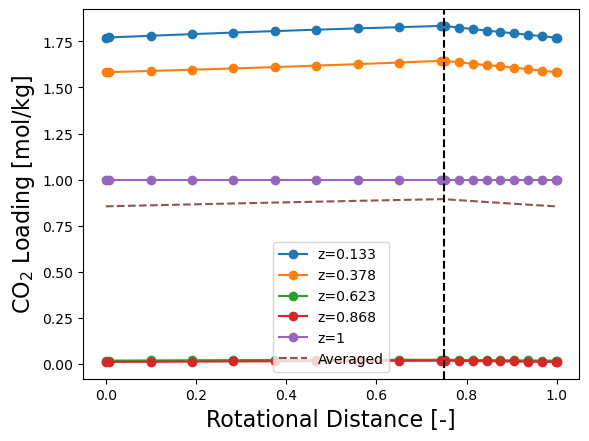

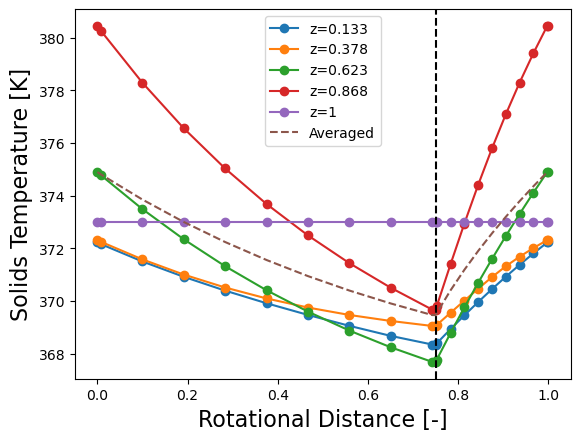

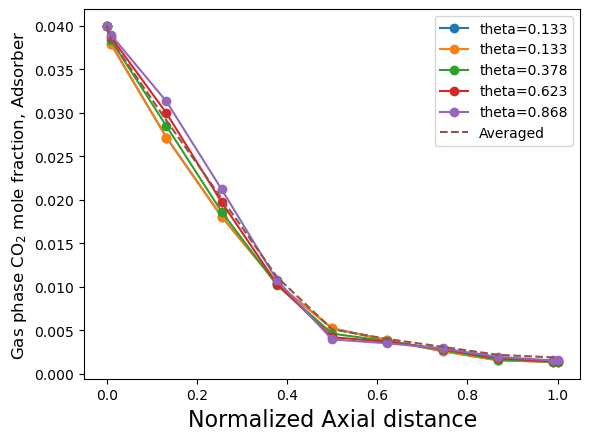

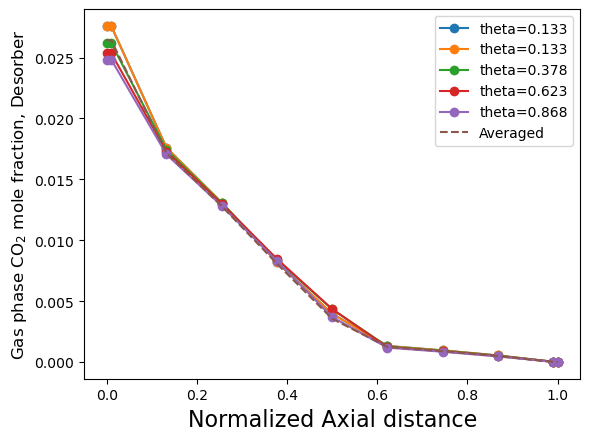

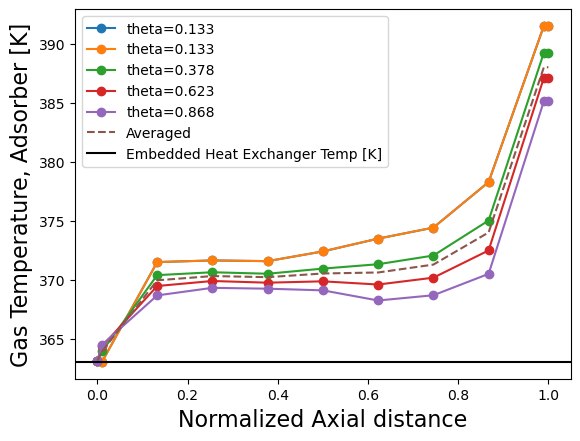

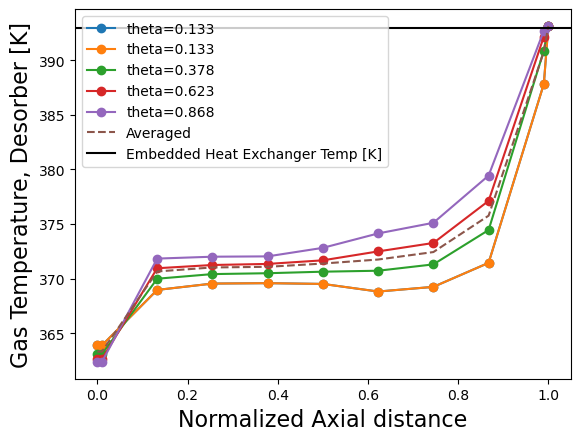

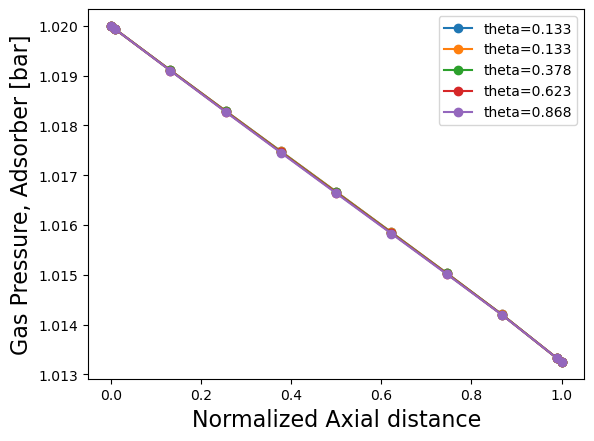

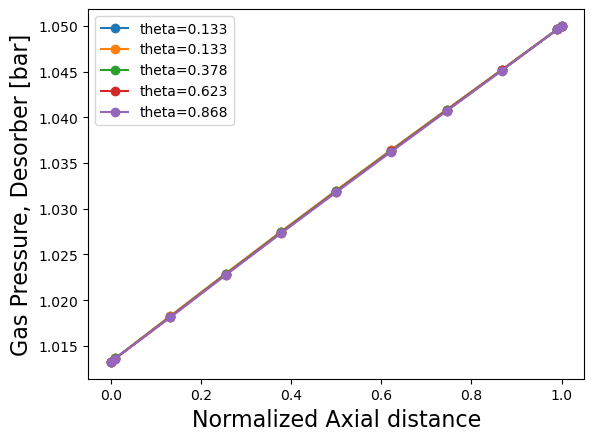

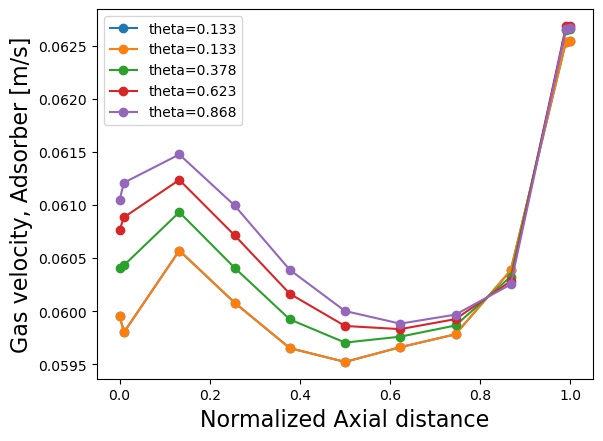

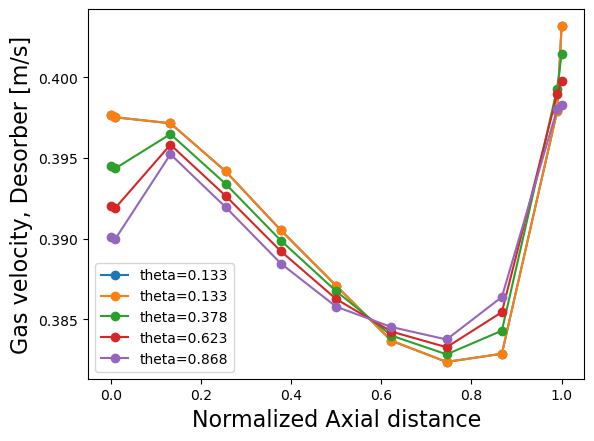

In [16]:
m.fs.RPB.plotting()

# Optimization

In [17]:
# add objective function
# create regularization parameter for the objective function
m.fs.RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# add objective
@m.fs.RPB.Objective()
def obj(RPB):
    return RPB.alpha_obj * RPB.energy_requirement[0] - (1 - RPB.alpha_obj) * RPB.productivity[0]

m.fs.RPB.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 24.656884879985036


In [18]:
# fix capture and free up inlet ads pressure
m.fs.RPB.ads.CO2_capture.fix(0.95)

m.fs.flue_gas_in.pressure.unfix()

In [19]:
# solve for fixed capture
solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
    "nlp_scaling_method": "user-scaling",
}
solver.solve(m, tee=True).write()

component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
Ipopt 3.13.2: max_iter=1000
bound_push=1e-22
halt_on_ampl_error=yes
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales an

In [20]:
m.fs.RPB.report()


Unit : fs.RPB                                                              Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value    : Units           : Fixed : Bounds
                 Adsorption Tx :   363.00 :          kelvin :  True : (0, None)
    Adsorption Volume Fraction :  0.75000 :   dimensionless :  True : (0.01, 0.99)
                   CO2 Capture :  0.95000 :   dimensionless :  True : (None, None)
                 Desorption Tx :   393.00 :          kelvin :  True : (0, None)
    Desorption Volume Fraction :  0.25000 :   dimensionless : False : (0.01, 0.99)
                      Diameter :   10.000 :           meter :  True : (0, None)
                        Length :   3.0000 :           meter :  True : (0.1, 10.001)
           Rotational Velocity : 0.010472 : radian / second :  True : (1e-05, 2)

    Expressions: 

    Key                : Value      : U

In [21]:
# set bounds for decision variables
m.fs.RPB.L.setlb(0.1)
m.fs.RPB.L.setub(20)
m.fs.RPB.L.pprint()

L : Bed Length [m]
    Size=1, Index=None, Units=m
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :   0.1 :     3 :    20 :  True :  True : PositiveReals


In [22]:
m.fs.RPB.ads.Tx.setlb(25+273)
m.fs.RPB.ads.Tx.setub(95+273)
m.fs.RPB.ads.Tx.pprint()

Tx : heat exchange fluid temperature, constant [K]
    Size=1, Index=fs._time, Units=K
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 :   298 :   363 :   368 :  True :  True : PositiveReals


In [23]:
m.fs.RPB.des.Tx.setlb(100+273)
m.fs.RPB.des.Tx.setub(160+273)
m.fs.RPB.des.Tx.pprint()

Tx : heat exchange fluid temperature, constant [K]
    Size=1, Index=fs._time, Units=K
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 :   373 :   393 :   433 :  True :  True : PositiveReals


In [24]:
m.fs.flue_gas_in.pressure.setub(1.2*1e5)
m.fs.flue_gas_in.pressure.setlb(1.0001*1e5)
m.fs.flue_gas_in.pressure.pprint()

pressure : Size=1, Index=fs._time, ReferenceTo=fs.flue_gas_in.properties[:].component('pressure')
    Key : Lower    : Value              : Upper    : Fixed : Stale : Domain
    0.0 : 100010.0 : 102032.48625654519 : 120000.0 : False : False : NonNegativeReals


In [25]:
m.fs.steam_sweep_feed.pressure.setub(1.2*1e5)
m.fs.steam_sweep_feed.pressure.setlb(1.0001*1e5)
m.fs.steam_sweep_feed.pressure.pprint()

pressure : Size=1, Index=fs._time, ReferenceTo=fs.steam_sweep_feed.properties[:].component('pressure')
    Key : Lower    : Value    : Upper    : Fixed : Stale : Domain
    0.0 : 100010.0 : 105000.0 : 120000.0 :  True :  True : NonNegativeReals


In [26]:
m.fs.RPB.w_rpm.setlb(0.00001)
m.fs.RPB.w_rpm.setub(0.01)
m.fs.RPB.w_rpm.pprint()

w_rpm : bed rotational speed [revolutions/min]
    Size=1, Index=fs._time, Units=turn/min
    Key : Lower : Value : Upper : Fixed : Stale : Domain
    0.0 : 1e-05 :   0.1 :  0.01 :  True :  True : PositiveReals


In [27]:
m.fs.RPB.ads.theta.setub(0.95)
m.fs.RPB.ads.theta.pprint()

theta : Fraction of bed occupied by the section[-]
    Size=1, Index=None
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :  0.01 :  0.75 :  0.95 :  True :  True : PositiveReals


In [30]:
# free up optimization variables
m.fs.RPB.L.unfix()
m.fs.RPB.ads.theta.unfix()
m.fs.steam_sweep_feed.pressure.unfix()
m.fs.RPB.ads.Tx.unfix()
m.fs.RPB.des.Tx.unfix()
m.fs.RPB.w_rpm.unfix()

In [ ]:
solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
    "nlp_scaling_method": "user-scaling",
}
solver.solve(m, tee=True).write()

In [31]:
# solve using conopt thorugh gams (usually works better than IPOPT)
results = SolverFactory("gams").solve(
    m,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

--- Job model.gms Start 08/28/24 11:46:53 40.4.0 d540b52e WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\40\gmsprmNT.txt
--- GAMS Parameters defined
    Input "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\model.gms"
    Output "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\output.lst"
    ScrDir "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\225m\"
    SysDir C:\GAMS\40\
    CurDir "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\"
    LogOption 3
Licensee: Medium MUD - 10 User License                   G211229|0002CN-GEN
          U.S. Department of Energy, National Energy Technology LaborDC9138
          C:\Users\hughesr\Documents\GAMS\gamslice.txt
          License Admin: Anthony P. Burgard, anthony.burgard@netl.doe.gov  
Processor information: 1 socket(s), 8 core(s), and 16 thread(s) available


In [32]:
m.fs.RPB.report()
m.fs.RPB.energy_requirement.display()
m.fs.RPB.productivity.display()


Unit : fs.RPB                                                              Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                        : Value      : Units           : Fixed : Bounds
                 Adsorption Tx :     342.38 :          kelvin : False : (298, 368)
    Adsorption Volume Fraction :    0.89702 :   dimensionless : False : (0.01, 0.95)
                   CO2 Capture :    0.95000 :   dimensionless :  True : (None, None)
                 Desorption Tx :     433.00 :          kelvin : False : (373, 433)
    Desorption Volume Fraction :    0.10298 :   dimensionless : False : (0.01, 0.99)
                      Diameter :     10.000 :           meter :  True : (0, None)
                        Length :     20.000 :           meter : False : (0.1, 20)
           Rotational Velocity : 0.00023863 : radian / second : False : (1e-05, 0.01)

    Expressions: 

    Key             

In [ ]:
diagtool = DiagnosticsToolbox(m)

In [ ]:
diagtool.config.variable_bounds_absolute_tolerance = 1e-6
diagtool.config.variable_bounds_relative_tolerance = 1e-6

In [ ]:
diagtool.display_variables_near_bounds()

pareto front generation (hasn't been updated for the IDAES model version)

In [ ]:
# # list of alpha values to use in the objective function
# alpha_list=[
#     0.0001,
#     0.001,
#     0.005,
#     0.01,
#     0.02,
#     0.05,
#     0.1,
#     0.2,
#     0.3,
#     0.4,
#     0.5,
#     0.6,
#     0.7,
#     0.8,
#     0.9,
#     0.925,
#     0.95,
#     0.975,
#     0.99,
#     0.999,
# ]

In [ ]:
# # optimize for every value and store the results
# E = []
# P = []

# for j in alpha_list:
#     RPB.alpha_obj = j

#     results = SolverFactory("gams").solve(
#         RPB,
#         tee=True,
#         keepfiles=True,
#         solver="conopt4",
#         tmpdir="temp",
#         add_options=["gams_model.optfile=1;"],
#     )

#     print(f'alpha = {j}, E={RPB.energy_requirement()}, P={RPB.productivity()}')

#     E.append(RPB.energy_requirement())
#     P.append(RPB.productivity())


In [ ]:
# pd.DataFrame({'alpha':alpha_list,'E':E,'P':P})

In [ ]:
# plt.scatter(E,P)

# Polishing step simulation and optimization (hasn't been updated for the IDAES model version)

start from previous optimized case

In [ ]:
# create pyomo model
# RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

In [ ]:
# # create regularization parameter for the objective function
# RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# # add objective
# @RPB.Expression()
# def obj(RPB):
#     return RPB.alpha_obj * RPB.energy_requirement - (1 - RPB.alpha_obj) * RPB.productivity

# RPB.objective = Objective(expr=RPB.obj)

# RPB.objective.pprint()

In [ ]:
# # set bounds for decision variables
# RPB.ads.L.setlb(0.01)
# RPB.ads.L.setub(40)
# RPB.des.L.setlb(0.01)
# RPB.des.L.setub(40)
# RPB.ads.L.pprint()

In [ ]:
# RPB.ads.Tx.setlb(25+273)
# RPB.ads.Tx.setub(95+273)
# RPB.ads.Tx.pprint()

In [ ]:
# RPB.des.Tx.setlb(100+273)
# RPB.des.Tx.setub(160+273)
# RPB.des.Tx.pprint()

In [ ]:
# RPB.ads.P_in.setub(1.5)
# RPB.ads.P_in.pprint()
# RPB.ads.P.setub(1.5)

In [ ]:
# RPB.des.P_in.setub(1.5)
# RPB.des.P_in.setlb(1.01325)
# RPB.des.P.setub(1.5)
# RPB.des.P_in.pprint()

In [ ]:
# RPB.ads.w_rpm.setlb(0.00001)
# RPB.ads.w_rpm.setub(0.1)
# RPB.ads.w_rpm.pprint()

In [ ]:
# # load a previous solution and solve (will also load the inlet gas feed conc.)
# from_json(RPB, fname="polishing step optimized solution 031824.json.gz", gz=True)

In [ ]:
# # solve using conopt thorugh gams
# results = SolverFactory("gams").solve(
#     RPB,
#     tee=True,
#     keepfiles=True,
#     solver="conopt4",
#     tmpdir="temp",
#     add_options=["gams_model.optfile=1;"],
# )

# Save Model

In [ ]:
# save model
iutil.to_json(m, fname="base case solution 012424.json.gz", gz=True, human_read=False)